# We import the libraries

# Libraries

In [1]:
import numpy as np
import json as json
from datetime import datetime
import matplotlib.pyplot as plt

# Our code
from src.tsp_genetic import TSP_Genetic
from src.parent_selection import parent_selection
from src.mutation import mutation
from src.crossover import crossover

# Functions

In [2]:
def read_data(filepath):
    """ Read the data from the file and return the distance matrix and the list of cities positions """

    with open(filepath, 'r') as file:
        distance_matrix = False
        city_list = False
        for line in file:
            line = line.strip()
            # Create the distance matrix and the list of cities
            if line.startswith('DIMENSION'):
                dimension = int(line.split()[-1])
                cities = np.zeros((dimension, 2))
                distances = np.zeros((dimension, dimension))
                i=0
                j=0
            
            # What do we do with the line
            if line.startswith('EDGE_WEIGHT_SECTION'):
                distance_matrix = True
                continue
            elif line.startswith('DISPLAY_DATA_SECTION'):
                distance_matrix = False
                city_list = True
                continue
            elif line.startswith('EOF'):
                break
            
            # Save data
            if distance_matrix:
                distances[i,] = [int(x) for x in line.split()]
                i += 1
            if city_list:
                cities[j,] = line.split()[-2:]
                j += 1
        
        return distances, cities

In [3]:
def create_population(size : int, cities : np.ndarray):
    """ Create the initial population """

    population = []
    for i in range(size):
        population.append(np.random.permutation(cities.shape[0]))
    
    return population

In [4]:
def grid_search(param_grid, cities, distances):
    """ 
    Perform a grid search over the parameters, returns the best parameters, the best distance, the best chromosome and all of the configurations and their best distance 

    Args:
        param_grid : dict
            Dictionary with the parameters to search over:
            "population_size" 
            "elitism" 
            "generations" 
            "m_rate" 
            "c_rate" 
            "select_parents" 
            "crossover"
            "mutation" 
            "tournament_size"
        cities : np.ndarray 
            Array with the cities positions
        distances : np.ndarray
            Distance matrix between the cities

    Returns:
        best_chromosome : np.ndarray
            The best chromosome found
        best_distance : float
            The distance of the best chromosome
        best_params : dict
            The parameters of the best configuration
        results : list
            List of dictionaries with the parameters and the distance of the best chromosome for each configuration considered
    """

    # Dictionary to store the results
    results = []
    best_distance = np.inf
    i=0

    for population_size in param_grid["population_size"]:
        # Generate the population
        population = create_population(population_size, cities)
        #Iterate over the parameters
        for generations in param_grid["generations"]:
            for m_rate in param_grid["m_rate"]:
                for c_rate in param_grid["c_rate"]:
                    for crossover in param_grid["crossover"]:
                        for mutation in param_grid["mutation"]:
                            for elitism in param_grid["elitism"]:
                                for select_parents in param_grid["select_parents"]:
                                    # Select the tournament size for tournament selection:
                                    if select_parents == "tournament_selection":
                                        for t_size in param_grid["tournament_size"]:
                                            genetic= TSP_Genetic(generations=generations,
                                                        print_results=False,
                                                        print_rate=10,
                                                        m_rate=m_rate,
                                                        c_rate=c_rate,
                                                        select_parents=select_parents,
                                                        tournament_size=t_size,
                                                        crossover=crossover,
                                                        crossover_call="()", # We dicided to use the default parameters for the crossover
                                                        mutation=mutation,
                                                        elitism=elitism,
                                                        results_path= "",
                                                        save_results=False)
                                            chromosome, distance = genetic.run(population,cities,distances)

                                            # Update the best parameters
                                            if distance < best_distance:
                                                best_distance = distance
                                                best_params = {
                                                    "population_size" : population_size,
                                                    "elitism" : elitism,
                                                    "generations" : generations,
                                                    "m_rate" : m_rate,
                                                    "c_rate" : c_rate,
                                                    "select_parents" : select_parents,
                                                    "crossover" : crossover,
                                                    "mutation" : mutation,
                                                    "tournament_size" : t_size
                                                }
                                                best_chromosome = chromosome

                                            # Save the results
                                            i+=1
                                            parameters = {
                                                "population_size" : population_size,
                                                "elitism" : elitism,
                                                "generations" : generations,
                                                "m_rate" : m_rate,
                                                "c_rate" : c_rate,
                                                "select_parents" : select_parents,
                                                "crossover" : crossover,
                                                "mutation" : mutation,
                                                "tournament_size" : t_size
                                            }
                                            results.append({
                                                "parameters" : parameters,
                                                "distance" : distance
                                            })
                                    # For the other selection methods
                                    else:
                                        t_size = None
                                        genetic= TSP_Genetic(generations=generations,
                                                            print_results=False,
                                                            print_rate=10,
                                                            m_rate=m_rate,
                                                            c_rate=c_rate,
                                                            select_parents=select_parents,
                                                            tournament_size=t_size,
                                                            crossover=crossover,
                                                            crossover_call="()", 
                                                            mutation=mutation,
                                                            elitism=elitism,
                                                            results_path= "",
                                                            save_results=False)
                                        chromosome, distance = genetic.run(population,cities,distances)
                                    
                                        # Update the best parameters
                                        if distance < best_distance:
                                            best_distance = distance
                                            best_params = {
                                                "population_size" : population_size,
                                                "elitism" : elitism,
                                                "generations" : generations,
                                                "m_rate" : m_rate,
                                                "c_rate" : c_rate,
                                                "select_parents" : select_parents,
                                                "crossover" : crossover,
                                                "mutation" : mutation,
                                                "tournament_size" : t_size
                                            }
                                            best_chromosome = chromosome

                                        # Save the results
                                        i+=1
                                        parameters = {
                                            "population_size" : population_size,
                                            "elitism" : elitism,
                                            "generations" : generations,
                                            "m_rate" : m_rate,
                                            "c_rate" : c_rate,
                                            "select_parents" : select_parents,
                                            "crossover" : crossover,
                                            "mutation" : mutation,
                                            "tournament_size" : t_size
                                        }
                                        results.append({
                                            "parameters" : parameters,
                                            "distance" : distance
                                        })
    return best_chromosome, best_distance, best_params, results

# Usage example

In [5]:
# We read the data:
distances,cities= read_data('bays29.tsp')

In [6]:
# Instantiate the genetic algorithm
genetic= TSP_Genetic(generations=100,
                    print_results=True,
                    print_rate=10,
                    m_rate=0.05,
                    c_rate=0.8,
                    select_parents="tournament_selection",
                    tournament_size=5,
                    crossover="OX1",
                    crossover_call="()", 
                    mutation="insertion",
                    elitism=3,
                    results_path= "results/distance_statistics.json",
                    save_results=True)

In [7]:
# Create the population:
population = create_population(200, cities)

INFO:root:Generation 0 - Best cromosome: [ 2 27  9 23 16 13 26 15 17  8 28  1 10 20  0  7  4 18 11 14 22 24  5 25
 19 21  3  6 12], Best path_distance: 4966.0


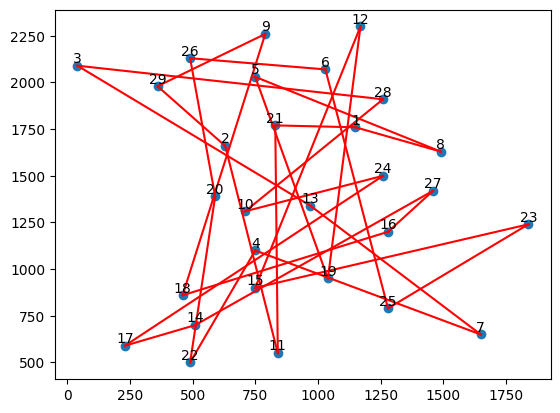

INFO:root:Generation 10 - Best cromosome: [20  7 26 18  9  3 19 12  6 22  0 25  5  8 11 23 17 13 10 21 16  1 15 27
  4  2 28 14 24], Best path_distance: 3892.0


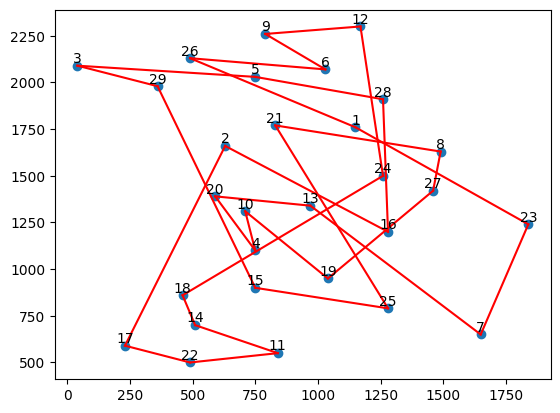

INFO:root:Generation 20 - Best cromosome: [ 7 26 18  3 19  9 12  6 22  0  5  8 11 25 23 15 17 13 10 21 16  1 20 27
  4  2 28 14 24], Best path_distance: 3496.0


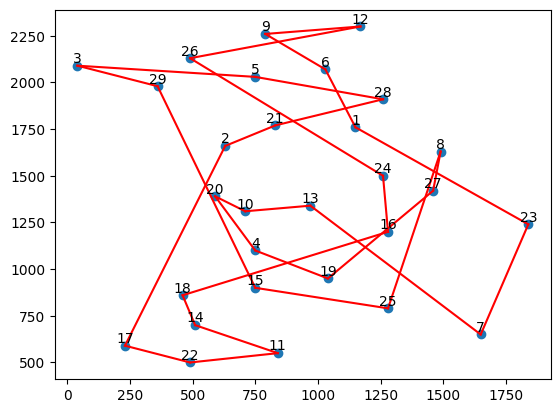

INFO:root:Generation 30 - Best cromosome: [26 18  3 19  9 12  6 22  7  0  5  8 11 25 23 15 17 13 10 21 16  1 20 27
  4  2 28 14 24], Best path_distance: 3286.0


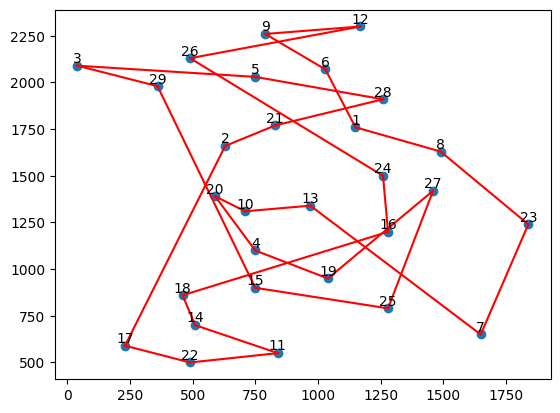

INFO:root:Generation 40 - Best cromosome: [26 18  3 19  9 12 22  7 27  5 11  8 25  0 23 15 17 13 10 21 16 20  4  2
 28  1 14 24  6], Best path_distance: 3053.0


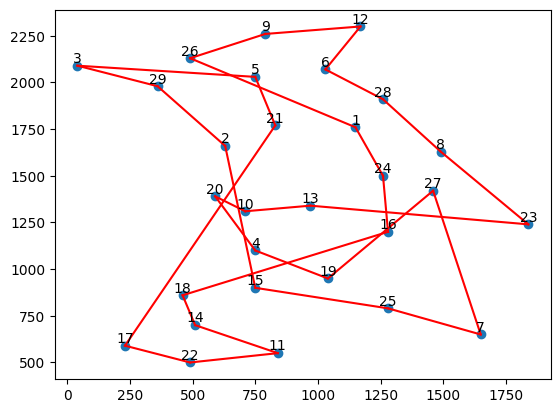

INFO:root:Generation 50 - Best cromosome: [26 18  3  9 12 22  7 27  5 11  8 25  0 23 15 17 13 10 21 16 20  4  2 28
  1 19 14 24  6], Best path_distance: 2997.0


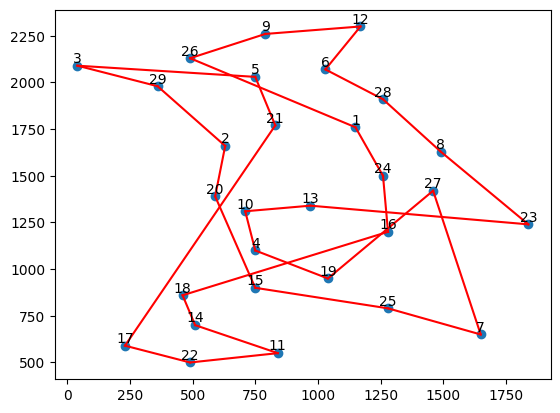

INFO:root:Generation 60 - Best cromosome: [26 18  3  9 12 22  7 27  5 11  8  0 23 15 14 17 13 10 21 16 20  4  2 28
 25  1 19 24  6], Best path_distance: 2937.0


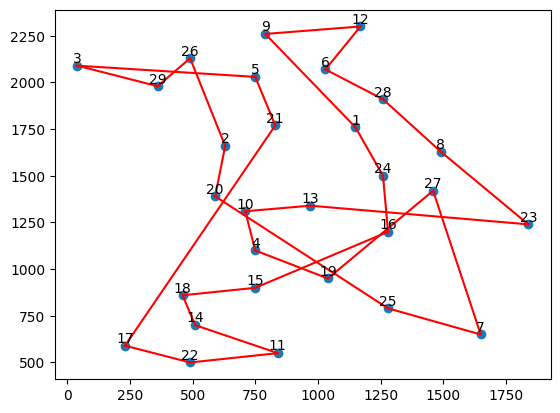

INFO:root:Generation 70 - Best cromosome: [26 18  3  9 12 22  7 27  5 11  8 20  0 23 15 14 17 13 10 21 16  4  2 28
 25  1 19 24  6], Best path_distance: 2924.0


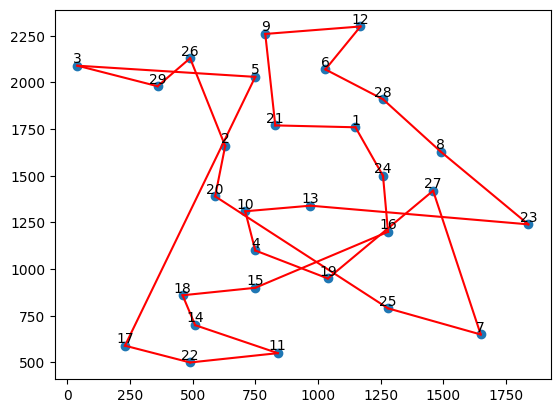

INFO:root:Generation 80 - Best cromosome: [26 22 18  3  9 12  7 27  5 11  8 20  0 23 15 14 17 13 10 21 16  4  2 28
 25  1 19 24  6], Best path_distance: 2900.0


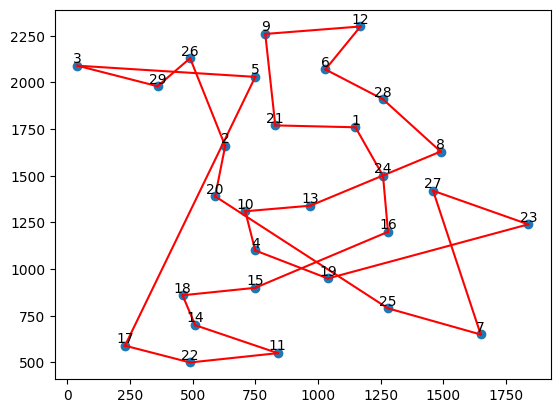

INFO:root:Generation 90 - Best cromosome: [22 26 15 18  3  9 12  7 27  5 11  8 20  0 23 10 14 17 13 21 16  4  2 28
 25  1 19 24  6], Best path_distance: 2766.0


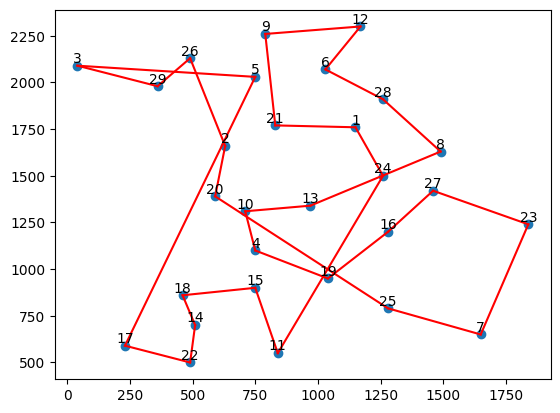

INFO:root:Generation 99 - Best cromosome: [22 26 15 18  3  9 12  7 27  5 11  8 20  0 23 10 14 17 13 21 16  4  2 28
 25  1 19 24  6], Best path_distance: 2766.0


In [8]:
# Run the genetic algorithm
final_population = genetic.run(population,cities,distances)

In [9]:
# Access the results for every generation metrics
import json

with open('results/distance_statistics.json', 'r') as file:
    data = json.load(file)

# The keys are the generation number
print(data[0])

{'0': {'mean_path_distance': 5983.3, 'median_path_distance': 6029.5, 'min_path_distance': 4966.0, 'max_path_distance': 7030.0}}


# Grid Seach

In [10]:
# Define the parameter grid
param_grid = {
    "population_size" : [50, 200],
    "elitism" : [0, 1, 3],
    "generations" : [100, 200],
    "m_rate" : [0.01, 0.05, 0.1],
    "c_rate" : [0.6, 0.8, 1],
    "select_parents" : ["tournament_selection", "roulette_selection","rank_roulette_selection","random_selection"],
    "crossover" : ["POS", "OX1"],
    "mutation" : ["exchange", "insertion", "IVM"],
    "tournament_size" : [3, 5] # Only for tournament selection
}

In [11]:
# Perform the grid search
best_chromosome, best_distance, best_params, results = grid_search(param_grid, cities, distances)                         

In [13]:
# Json file with the results
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
results_file=f'results/grid_search_results_{timestamp}.json'

# Save the results for every configuration:
with open(results_file, "w") as f:
    json.dump({index: result for index, result in enumerate(results)}, f) # Index is the index of the configuration

In [14]:
# Best Results:
print(f'The number of configurations considered was: {len(results)}')
print(f'The best chromosome found was: {best_chromosome}')
print(f'The best distance found was: {best_distance}')
print(f'The best parameters were: {best_params}')

The best chromosome found was: [10 21 13 16 17 14  3  9 19 12 20  1  2 28 25  4  8 11  5 27  0 23  7 26
 22  6 24 15 18]
The best distance found was: 2034.0
The best parameters were: {'population_size': 200, 'elitism': 3, 'generations': 200, 'm_rate': 0.1, 'c_rate': 0.6, 'select_parents': 'tournament_selection', 'crossover': 'OX1', 'mutation': 'insertion', 'tournament_size': 5}


# Graphical Analysis

In [22]:
# Create a dataframe with the results
import pandas as pd

data = []
for configuration in results:
    row ={ 
        "population_size": configuration["parameters"]["population_size"],
        "elitism": configuration["parameters"]["elitism"],
        "generations": configuration["parameters"]["generations"],
        "m_rate": configuration["parameters"]["m_rate"],
        "c_rate": configuration["parameters"]["c_rate"],
        "select_parents": configuration["parameters"]["select_parents"],
        "crossover": configuration["parameters"]["crossover"],
        "mutation": configuration["parameters"]["mutation"],
        "tournament_size": configuration["parameters"]["tournament_size"],
        "distance": configuration["distance"]
        }
    data.append(row)
data = pd.DataFrame(data)

In [23]:
data

,population_size,elitism,generations,m_rate,c_rate,select_parents,crossover,mutation,tournament_size,distance
0,50,0,100,0.01,0.6,tournament_selection,POS,exchange,5.0,4123.0
1,50,0,100,0.01,0.6,roulette_selection,POS,exchange,NaN,4913.0
2,50,0,100,0.01,0.6,rank_roulette_selection,POS,exchange,NaN,5935.0
3,50,0,100,0.01,0.6,random_selection,POS,exchange,NaN,6159.0
4,50,1,100,0.01,0.6,tournament_selection,POS,exchange,5.0,4358.0
...,...,...,...,...,...,...,...,...,...,...
2587,200,1,200,0.10,1.0,random_selection,OX1,IVM,NaN,3910.0
2588,200,3,200,0.10,1.0,tournament_selection,OX1,IVM,5.0,2519.0
2589,200,3,200,0.10,1.0,roulette_selection,OX1,IVM,NaN,2885.0
2590,200,3,200,0.10,1.0,rank_roulette_selection,OX1,IVM,NaN,2304.0


## Population Size Analysis

/tmp/ipykernel_139295/566915515.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([population_50, population_200], labels=['Population Size = 50', 'Population Size = 200'])


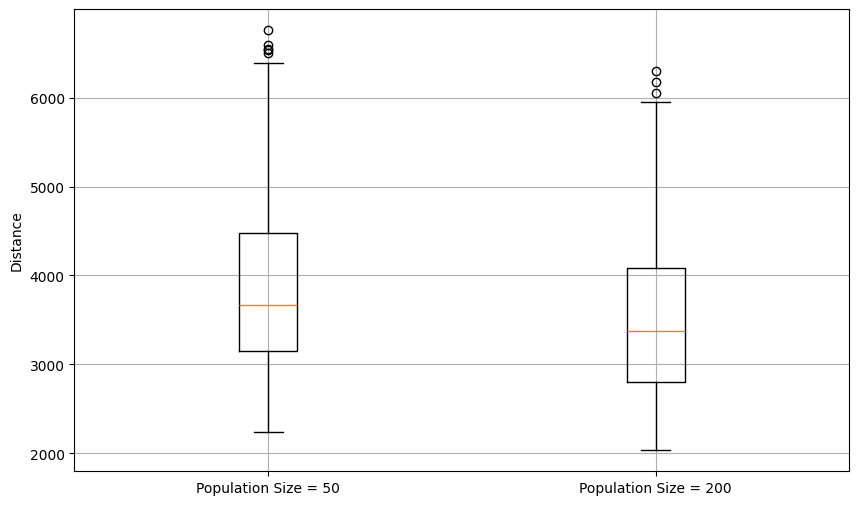

<Figure size 640x480 with 0 Axes>

In [26]:
population_50 = data[data['population_size']==50]['distance']
population_200 = data[data['population_size']==200]['distance']

# Plot the results
plt.figure(figsize=(10, 6))
plt.boxplot([population_50, population_200], labels=['Population Size = 50', 'Population Size = 200'])
plt.ylabel('Distance')
plt.grid(True)
plt.show()
plt.savefig('results/population_size_boxplot.png')



## Elitism

/tmp/ipykernel_139295/3342350379.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([elitism_0, elitism_1,elitism_3], labels=['No Elitism', 'Saving the Best Chromosome', 'Saving the 3 Best Chromosomes'])


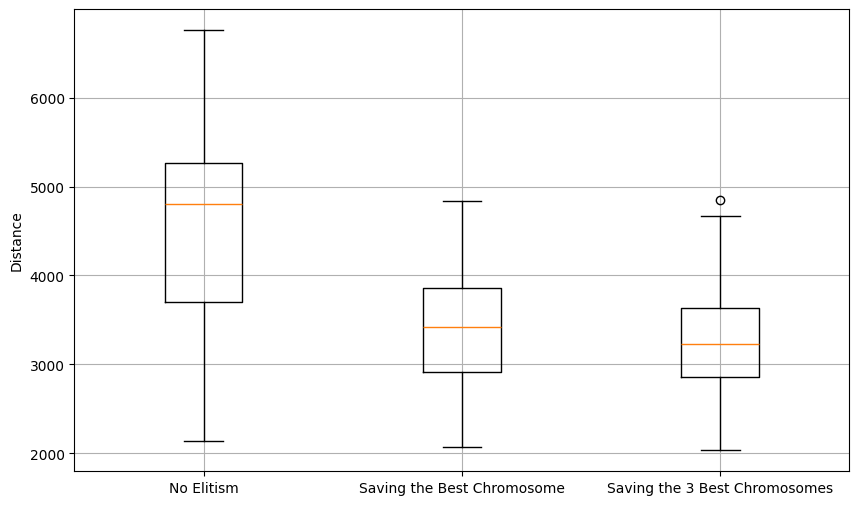

<Figure size 640x480 with 0 Axes>

In [27]:
elitism_0 = data[data['elitism']==0]['distance']
elitism_1 = data[data['elitism']==1]['distance']
elitism_3 = data[data['elitism']==3]['distance']

# Plot the results
plt.figure(figsize=(10, 6))
plt.boxplot([elitism_0, elitism_1,elitism_3], labels=['No Elitism', 'Saving the Best Chromosome', 'Saving the 3 Best Chromosomes'])
plt.ylabel('Distance')
plt.grid(True)
plt.show()
plt.savefig('results/elitism_boxplot.png')


## Generation

/tmp/ipykernel_139295/1069125337.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([generations_100, generations_200], labels=['Number of Generations = 100', 'Number of Generations = 200'])


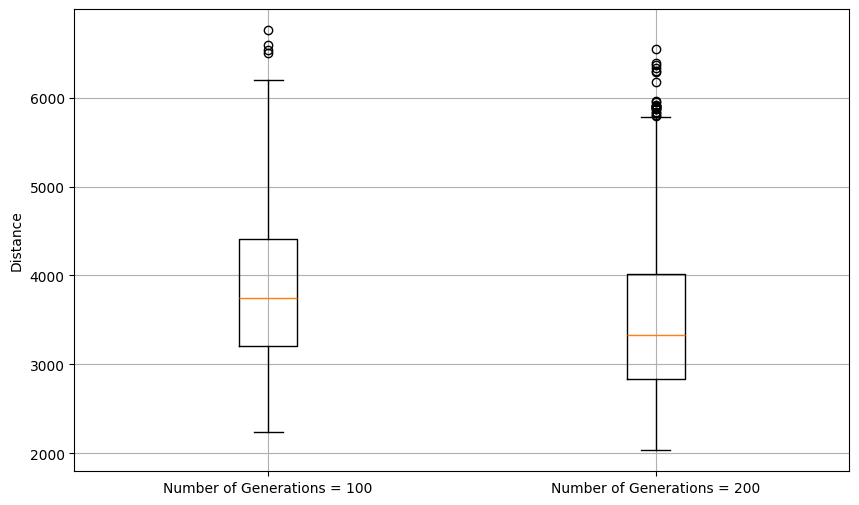

<Figure size 640x480 with 0 Axes>

In [28]:
generations_100 = data[data['generations']==100]['distance']
generations_200 = data[data['generations']==200]['distance']

# Plot the results
plt.figure(figsize=(10, 6))
plt.boxplot([generations_100, generations_200], labels=['Number of Generations = 100', 'Number of Generations = 200'])
plt.ylabel('Distance')
plt.grid(True)
plt.show()
plt.savefig('results/generations_boxplot.png')


## Mutation Rate

/tmp/ipykernel_139295/2146080545.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([m_rate_001, m_rate_005, m_rate_01], labels=['Mutation Rate = 0.01', 'Mutation Rate = 0.05', 'Mutation Rate = 0.1'])


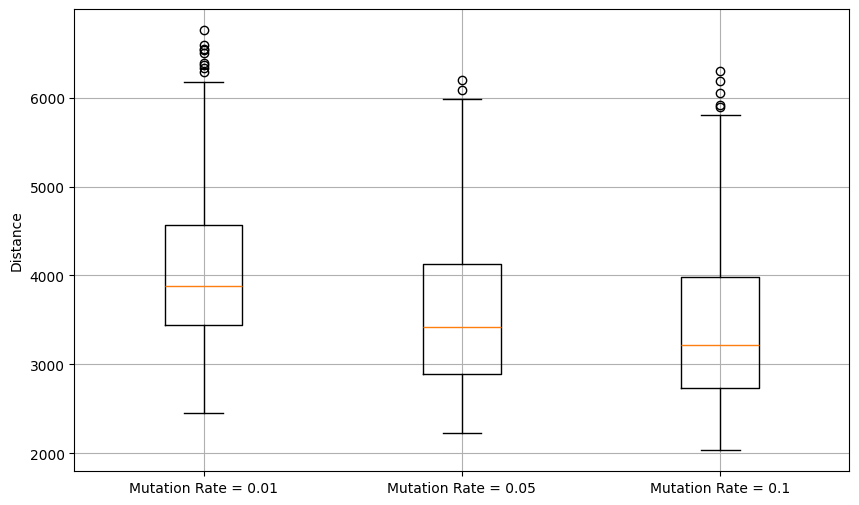

<Figure size 640x480 with 0 Axes>

In [29]:
m_rate_001 = data[data['m_rate'] == 0.01]['distance']
m_rate_005 = data[data['m_rate'] == 0.05]['distance']
m_rate_01 = data[data['m_rate'] == 0.1]['distance']

# Plot the results
plt.figure(figsize=(10, 6))
plt.boxplot([m_rate_001, m_rate_005, m_rate_01], labels=['Mutation Rate = 0.01', 'Mutation Rate = 0.05', 'Mutation Rate = 0.1'])
plt.ylabel('Distance')
plt.grid(True)
plt.show()
plt.savefig('results/mutation_rate_boxplot.png')

## Crossover Rate

/tmp/ipykernel_139295/1047073890.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([c_rate_06, c_rate_08, c_rate_1], labels=['Crossover Rate = 0.6', 'Crossover Rate = 0.8', 'Crossover Rate = 1.0'])


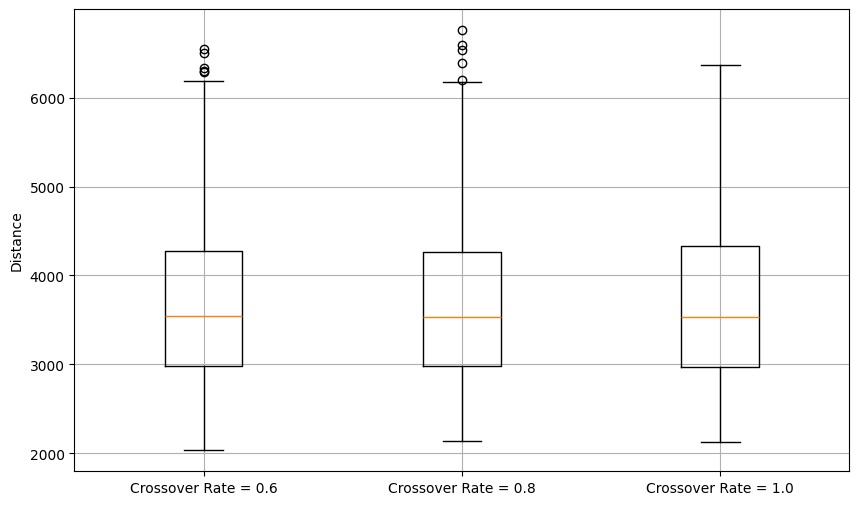

<Figure size 640x480 with 0 Axes>

In [30]:
c_rate_06 = data[data['c_rate'] == 0.6]['distance']
c_rate_08 = data[data['c_rate'] == 0.8]['distance']
c_rate_1 = data[data['c_rate'] == 1.0]['distance']

# Plot the results
plt.figure(figsize=(10, 6))
plt.boxplot([c_rate_06, c_rate_08, c_rate_1], labels=['Crossover Rate = 0.6', 'Crossover Rate = 0.8', 'Crossover Rate = 1.0'])
plt.ylabel('Distance')
plt.grid(True)
plt.show()
plt.savefig('results/crossover_rate_boxplot.png')

## Parent Selection Method

/tmp/ipykernel_139295/3122131634.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([tournament_selection_3, tournament_selection_5, roulette_selection, rank_roulette_selection, random_selection],


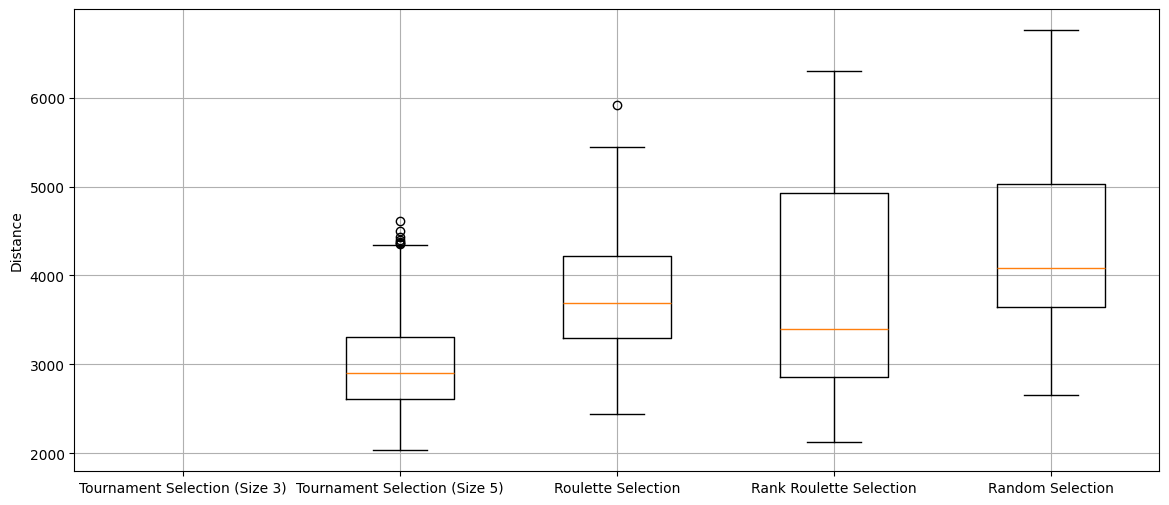

<Figure size 640x480 with 0 Axes>

In [35]:
tournament_selection_3 = data[(data['select_parents'] == 'tournament_selection') & (data['tournament_size']==3)]['distance']
tournament_selection_5 = data[(data['select_parents'] == 'tournament_selection') & (data['tournament_size']==5)]['distance']
roulette_selection = data[data['select_parents'] == 'roulette_selection']['distance']
rank_roulette_selection = data[data['select_parents'] == 'rank_roulette_selection']['distance']
random_selection = data[data['select_parents'] == 'random_selection']['distance']

# Plot the results
plt.figure(figsize=(14, 6))
plt.boxplot([tournament_selection_3, tournament_selection_5, roulette_selection, rank_roulette_selection, random_selection], 
            labels=['Tournament Selection (Size 3)', 'Tournament Selection (Size 5)', 'Roulette Selection', 'Rank Roulette Selection', 'Random Selection'])
plt.ylabel('Distance')
plt.grid(True)
plt.show()
plt.savefig('results/parent_selection_method_boxplot.png')

## Crossover Method

In [ ]:
pos_crossover = data[data['crossover'] == 'POS']['distance']
ox1_crossover = data[data['crossover'] == 'OX1']['distance']

# Plot the results
plt.figure(figsize=(10, 6))
plt.boxplot([pos_crossover, ox1_crossover], labels=['POS Crossover', 'OX1 Crossover'])
plt.ylabel('Distance')
plt.grid(True)
plt.show()
plt.savefig('results/crossover_method_boxplot.png')

## Mutation Method

In [ ]:
insertion_mutation = data[data['mutation'] == 'insertion']['distance']
exchange_mutation = data[data['mutation'] == 'exchange']['distance']
ivm_mutation = data[data['mutation'] == 'IVM']['distance']

# Plot the results
plt.figure(figsize=(10, 6))
plt.boxplot([insertion_mutation, exchange_mutation, ivm_mutation], 
            labels=['Insertion Mutation', 'Exchange Mutation', 'IVM Mutation'])
plt.ylabel('Distance')
plt.grid(True)
plt.show()
plt.savefig('results/mutation_method_boxplot.png')